In [5]:
import pandas as pd
import numpy as np
import zipfile 
import io
import os
import concurrent.futures
import time
import subprocess
import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter


# Data Loader

## Function to unzip folder

In [5]:
# Extract the zip and save in interim
data_folder = '../data'
zip_flight_data= data_folder + '/external/itineraries_csv.zip'

extract_directory = data_folder +'/interim'

# Read the zip file
with zipfile.ZipFile(zip_flight_data, 'r') as z:
    z.extractall(extract_directory)

print(f"Extracted {zip_flight_data} to {extract_directory}")



Extracted ../data/external/itineraries_csv.zip to ../data/interim


## Function to unzip CSV and save them as 1 per airport

In [8]:
# CHAMPION FILE EXTRACTOR
def process_folder(folder):    
    df_list = []
    files = os.listdir(f"../data/interim/itineraries_csv/{folder}")
    for file in files:
        file_path = f"../data/interim/itineraries_csv/{folder}/{file}"
        if file.endswith('.zip'):
            df=pd.read_csv(file_path, compression='zip')
            df_list.append(df)
    df_list = pd.concat(df_list)
    df_list.to_csv(f"../data/interim/{folder}.csv", index=False)
    print(f"Saved {folder}.csv")
root_dir = "../data/interim/itineraries_csv"
folders = [entry.name for entry in os.scandir(root_dir) if entry.is_dir()]

# Measure execution time
start_time = time.time()

# Limit the number of threads
max_threads = 4

# Use multiprocessing.Pool to run the folder processing function in parallel
with multiprocessing.Pool(processes=max_threads) as pool:
    pool.map(process_folder, folders)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

Saved IAD.csv
Saved JFK.csv
Saved PHL.csv
Saved ORD.csv
Saved OAK.csv
Saved DTW.csv
Saved DEN.csv
Saved LAX.csv
Saved CLT.csv
Saved EWR.csv
Saved MIA.csv
Saved BOS.csv
Saved LGA.csv
Saved ATL.csv
Saved SFO.csv
Saved DFW.csv
Execution time: 56.55 seconds


In [9]:
# Remove the processed folders to save storage space
subprocess.run(f"rm -rf ../data/interim/itineraries_csv", shell=True)
subprocess.run(f"rm -rf ../data/interim/__MACOSX", shell=True)
print("Removed folders")


Removed folders


# Read in airport CSV

In [17]:
df = pd.read_csv('../data/interim/ATL.csv')


In [18]:
df.describe( include='all') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874069 entries, 0 to 874068
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   legId                              874069 non-null  object 
 1   searchDate                         874069 non-null  object 
 2   flightDate                         874069 non-null  object 
 3   startingAirport                    874069 non-null  object 
 4   destinationAirport                 874069 non-null  object 
 5   travelDuration                     874069 non-null  object 
 6   isBasicEconomy                     874069 non-null  bool   
 7   isRefundable                       874069 non-null  bool   
 8   isNonStop                          874069 non-null  bool   
 9   totalFare                          874069 non-null  float64
 10  totalTravelDistance                769021 non-null  float64
 11  segmentsDepartureTimeEpochSeconds  8740

## Clean up data

In [19]:
# Function to clean and convert the data
def transform_data(df):

    # Convert date columns
    date_columns = ['searchDate', 'flightDate']
    df[date_columns] = df[date_columns].apply(pd.to_datetime)

    # Convert float to numeric
    float_columns = ['totalFare','totalTravelDistance']
    for col in float_columns:
        df[col] = pd.to_numeric(df[col],errors='coerce').astype('float32')

    # Drop rows
    df = df.dropna(subset=['segmentsEquipmentDescription','segmentsAirlineName'])
    return df

    


In [ ]:
# Covert the segment data into new variables

airports= ['ATL','BOS','DEN','DFW','EWR','JFK','LAX','LGA','MIA','OAK','ORD','PHL','SFO']
# dictionary for the correct time offsets
time_offsets = {'ATL': '-04:00', 'BOS' : '-04:00' , 'DEN':'-06:00', 'DFW':'-05:00' ,'EWR':'-04:00',   'JFK': '-04:00','LAX': '-07:00', 'LGA': '-04:00', 'MIA': '-04:00', 'OAK': '-07:00', 'ORD': '-05:00', 'PHL': '-04:00', 'SFO': '-07:00'}

# Departure Hour Processing
def process_segments_DepartTime(df):
    # Split the departure time
    print("Shape before processing: ", df.shape)
    df["segmentsDepartureTimeRaw_hour"] = df["segmentsDepartureTimeRaw"].str.split("|").str[0]
    airportcode = df["startingAirport"][0]
    correct_time_offset = time_offsets[airportcode]

    # filter for departure time hour that has the correct time offset
    df = df[df["segmentsDepartureTimeRaw_hour"].str[-6:] == correct_time_offset]
    print("Shape after processing departure time: ", df.shape)

    # check date difference between the  segmentsDepartureTimeRaw_hour aNd flight date and eliminate any that dont match
    df["segmentsDepartureTimeRaw_hour"] = pd.to_datetime(
        df["segmentsDepartureTimeRaw_hour"]
    ).dt.tz_localize(None)
    df = df[(df["segmentsDepartureTimeRaw_hour"] - df["flightDate"]).dt.days == 0]
    print("Shape after filtering segment departure not the same as flight date: ", df.shape)

    # extract out the hour of the day
    df["segmentsDepartureTimeRaw_hour"] = df["segmentsDepartureTimeRaw_hour"].dt.hour.astype("int8")

    return df

# Cabin Class Encoding
cabin_class_encoding = {
    "coach": 1,
    "premium coach": 2,
    "business": 3,
    "first": 4,
}

def process_segments_CabinClass(df):
    # Split the Cabin class
    df["CabinCode"] = df["segmentsCabinCode"].str.split("\\|\\|")
    
    # apply cabin_class_encoding on the cabin class
    df["CabinCode"] = df["CabinCode"].apply(lambda x: [cabin_class_encoding.get(i, 0) for i in x])

    # get the average of the cabin class
    df["CabinCode"] = df["CabinCode"].apply(lambda x: np.mean(x) if isinstance(x, list) else x)

    return df

# Airline Name Processing

# Airline Encoding 
# 1: Ultra Low Cost, 2: Budget, 3: Regional, 4: Full Service
airline_type_encoding = {
    'JetBlue Airways': 2,
    'Sun Country Airlines': 2,
    'United': 4,
    'Delta': 4,
    'Key Lime Air': 3,
    'Boutique Air': 3,
    'Contour Airlines': 3,
    'Spirit Airlines': 1,
    'American Airlines': 4,
    'Alaska Airlines': 4,
    'Southern Airways Express': 3,
    'Frontier Airlines': 1,
    'Hawaiian Airlines': 4,
    'Cape Air': 3
}

# Airline Category Mapping
def process_segments_AirlineNameScore(df):
    df["AirlineName"] = df["segmentsAirlineName"].str.split("\\|\\|")
    df["AirlineNameScore"] = df["AirlineName"].apply(lambda x: [airline_type_encoding.get(i, 0) for i in x])
    df["AirlineNameScore_max"]= df["AirlineNameScore"].apply(lambda x: np.max(x) if isinstance(x, list) else x) 
    return df






In [25]:
df_airline = process_segments_AirlineNameScore(df)


In [ ]:

# extract unique airline names from each segment
def process_segments_AirlineName(df):
    df["segmentsAirlineName"] = df["segmentsAirlineName"].str.split("\\|\\|")
    exploded_df = df.explode('segmentsAirlineName')

    # Get the unique values for the entire column
    unique_airline_names = exploded_df['segmentsAirlineName'].unique()


    return unique_airline_names

def process_all_airports(directory, airports):
    all_unique_airline_names = set()
    
    for airport in airports:
        file_path = os.path.join(directory, f'{airport}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            unique_airline_names = process_segments_AirlineName(df)
            all_unique_airline_names.update(unique_airline_names)
        else:
            print(f"File not found: {file_path}")
    
    return list(all_unique_airline_names)

# Example usage
directory = '../data/interim'
airports = ['ATL','BOS','DEN','DFW','EWR','JFK','LAX','LGA','MIA','OAK','ORD','PHL','SFO']
all_unique_airline_names = process_all_airports(directory, airports)

print("All unique airline names:", all_unique_airline_names)

All unique airline names: ['JetBlue Airways', 'Sun Country Airlines', 'United', 'Delta', 'Key Lime Air', 'Boutique Air', 'Contour Airlines', 'Spirit Airlines', 'American Airlines', 'Alaska Airlines', 'Southern Airways Express', 'Frontier Airlines', 'Hawaiian Airlines', 'Cape Air']


In [ ]:
df_segments = process_segments_CabinClass(transform_data(df))
print(df_segments['segmentsCabinCode'].unique())
df_segments= process_segments_DepartTime(df_segments)

In [7]:
df_segments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 848482 entries, 0 to 874068
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   legId                              848482 non-null  object        
 1   searchDate                         848482 non-null  datetime64[ns]
 2   flightDate                         848482 non-null  datetime64[ns]
 3   startingAirport                    848482 non-null  object        
 4   destinationAirport                 848482 non-null  object        
 5   travelDuration                     848482 non-null  object        
 6   isBasicEconomy                     848482 non-null  bool          
 7   isRefundable                       848482 non-null  bool          
 8   isNonStop                          848482 non-null  bool          
 9   totalFare                          848482 non-null  float32       
 10  totalTravelDistance      

## Run some graphs to visualise the data

In [51]:
# function to plot the data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




# Function to plot the data
def plot_data(df):
    # CHange width of all the plots
    plt.rcParams['figure.figsize'] = [10, 6]
    
    
    # # Plot the total fare distribution
    # sns.histplot(df['totalFare'], kde=True)
    # plt.title('Total Fare Distribution')
    # plt.show()

    # # Plot the total travel distance distribution
    # sns.histplot(df['totalTravelDistance'], kde=True)
    # plt.title('Total Travel Distance Distribution')
    # plt.show()

    # # #plot the segmentsAirlineCode, destinationAirport, segmentCabinCode in a facet grid
    # # sns.catplot(data=df, kind='count', x='segmentsAirlineCode', col='destinationAirport', row='segmentsCabinCode')
    # # plt.show()

    # # Plot the total fare vs total travel distance
    # sns.scatterplot(data=df, x='totalFare', y='totalTravelDistance')
    # plt.title('Total Fare vs Total Travel Distance')
    # plt.show()

    # # Function for cat plots
    # def catplot(x, df):
    #     g=sns.catplot(data=df, kind='violin', x=x, y='totalFare', height=5, aspect=4)
    #     return g
    
    # # Plot the destination city vs total fare
    # catplot('destinationAirport', df)
    # plt.title('Destination City vs Total Fare')
    # plt.show()

    # # Plot the departure time vs total fare
    # catplot('segmentsDepartureTimeRaw_hour', df)
    # plt.title('Departure Time vs Total Fare')
    # plt.show()

    # # Plot the distributions of total fare by isNonStop, isRefundable, and isBasicEconomy
    # catplot('isNonStop', df)
    # plt.title('Is Non Stop vs Total Fare')
    # plt.show()
    # catplot('isRefundable', df)
    # plt.title('Is Refundable vs Total Fare')
    # plt.show()
    # catplot('isBasicEconomy', df)
    # plt.title('Is Basic Economy vs Total Fare')
    # plt.show()

    # Plot the frequency of the cabincode average
    sns.histplot(df['CabinCode'], kde=True)






    






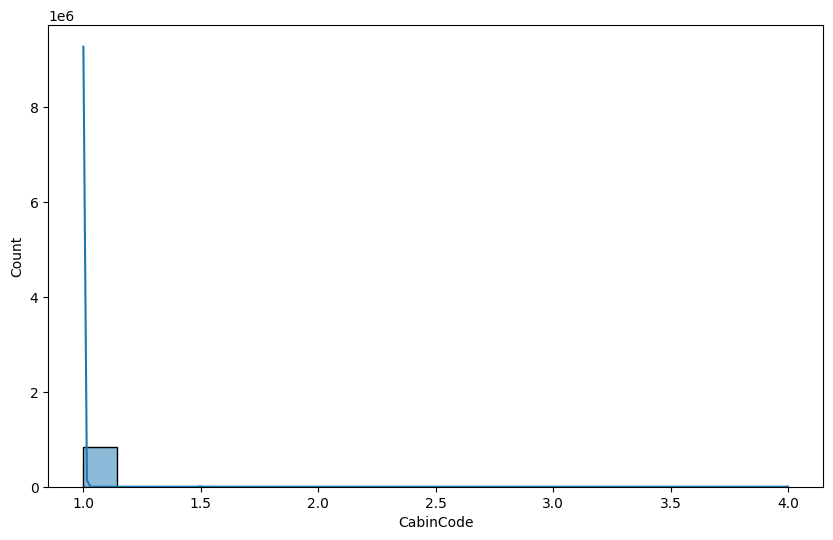

In [56]:
plot_data(df_segments)

In [12]:
# Tabulate the cabin code volume and average total fare
CabinAvgFare=df_segments.groupby('segmentsCabinCode')['totalFare'].agg(['count','mean'])

# $ tabulate the cabin code by every 0.5 and average total fare
CabinAvgFare=df_segments.groupby(pd.cut(df_segments['CabinCode'], np.arange(0, 5.5, 0.5)))['totalFare'].agg(['count','mean'])

CabinAvgFare




/tmp/ipykernel_1395/185497639.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  CabinAvgFare=df_segments.groupby(pd.cut(df_segments['CabinCode'], np.arange(0, 5.5, 0.5)))['totalFare'].agg(['count','mean'])


,count,mean
CabinCode,,
"(0.0, 0.5]",0,NaN
"(0.5, 1.0]",846222,349.695160
"(1.0, 1.5]",993,652.053589
"(1.5, 2.0]",336,958.629944
"(2.0, 2.5]",517,557.219849
"(2.5, 3.0]",7,993.971375
"(3.0, 3.5]",0,NaN
"(3.5, 4.0]",407,1410.381592
"(4.0, 4.5]",0,NaN


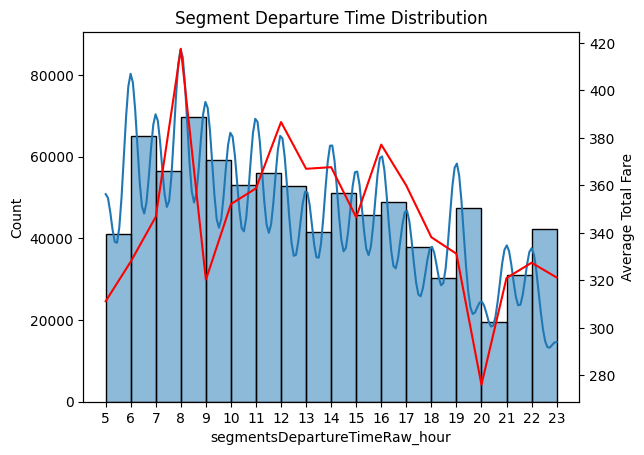

In [22]:
# visualise segment departure time
bin_edges = np.arange(5, 24, 1)  # Bin edges from 5 to 23, inclusive
sns.histplot(df_segments['segmentsDepartureTimeRaw_hour'], kde=True, bins=bin_edges)
plt.xticks(np.arange(0, 24, 1))

# add average totalFare by hour to the plot
# put on 2nd axis
plt.twinx()


sns.lineplot(data=df_segments.groupby('segmentsDepartureTimeRaw_hour')['totalFare'].mean(), color='red')
plt.ylabel('Average Total Fare')


#put 



plt.title('Segment Departure Time Distribution')
plt.show()


In [27]:
# Top desitations out of ATL
top_destinations = df_segments['destinationAirport'].value_counts()


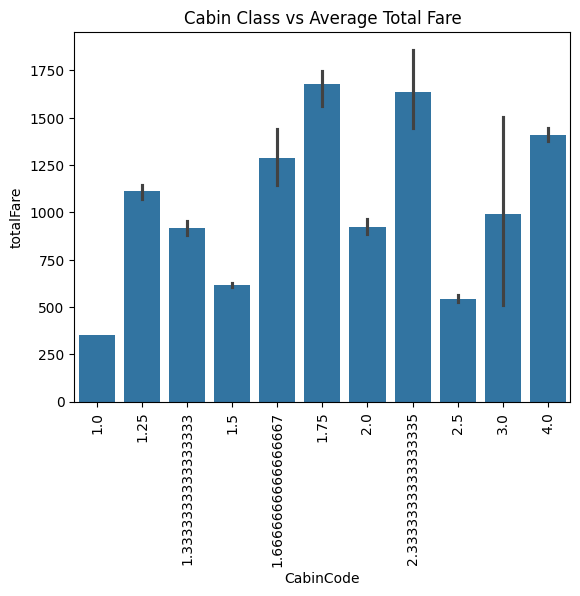

In [10]:
# generate plot of cabin class vs average totalfare
sns.barplot(data=df_segments, x='CabinCode', y='totalFare')
plt.title('Cabin Class vs Average Total Fare')
plt.xticks(rotation=90)
# Limit the number of decimal points on the y-axis to 2
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()



In [ ]:
# Graph the avg prices by airline
# Airline Category Mapping
def process_segments_AirlineNameScore(df):
    df["AirlineName"] = df["segmentsAirlineName"].str.split("\\|\\|")
    df["AirlineNameScore"] = df["AirlineName"].apply(lambda x: [airline_type_encoding.get(i, 0) for i in x])
    df["AirlineNameScore_max"]= df["AirlineNameScore"].apply(lambda x: np.max(x) if isinstance(x, list) else x) 
    return df
# graph for economy cabine segment
filtered_df = df_airline[df_airline['segmentsCabinCode'] == 'coach']

# Define a custom color palette
# Define colors for each airline type
type_colors = {
    1: '#ff7f0e',  # Ultra Low Cost
    2: '#1f77b4',  # Budget
    3: '#2ca02c',  # Regional
    4: '#d62728'   # Full Service
}

# Create the airline_palette based on the airline_type_encoding
airline_palette = {airline: type_colors[airline_type_encoding[airline]] for airline in airline_type_encoding}

# Create a FacetGrid to plot data for different destination airports
g = sns.FacetGrid(filtered_df, col='destinationAirport', col_wrap=3, height=4)

# Map the barplot to the FacetGrid with the custom color palette
g.map_dataframe(sns.barplot, x='segmentsAirlineName', y='totalFare', palette=airline_palette, order=filtered_df['segmentsAirlineName'].unique())

# Rotate x-axis labels for better readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
# Define colors for each airline type
type_colors = {
    1: '#ff7f0e',  # Ultra Low Cost
    2: '#1f77b4',  # Budget
    3: '#2ca02c',  # Regional
    4: '#d62728'   # Full Service
}

# Create the airline_palette based on the airline_type_encoding
airline_palette = {airline: type_colors[airline_type_encoding[airline]] for airline in airline_type_encoding}

# Add a legend

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=legend_labels[label])
           for label, color in type_colors.items()]
g.add_legend(title='Airline Type', handles=handles)

# Show the plot
plt.show()
